# Code

## Get Data

In [190]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import threading
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
import copy

In [256]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_test = X[90:]
y_test = y[90:]
X = X[:90]
y = y[:90]


print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

X shape: (10, 2)
y shape: (10,)


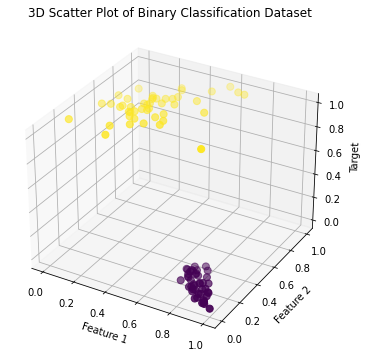

In [257]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

feature1 = X[:, 0]
feature2 = X[:, 1]
ax.scatter(feature1, feature2, y, c=y, cmap='viridis', s=50)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

plt.title('3D Scatter Plot of Binary Classification Dataset')
plt.show()

## Classes

In [258]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.layer1 = nn.Linear(input_shape[0], 5, bias=True)
        self.layer2 = nn.Linear(5, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)

        return x

In [259]:
class Node():
    num_epochs = 10
    batch_size = 32
    lr = 0.005

    def __init__(self, model, X, y, central):
        self.model = model
        self.central = central
        self.train_loader = self.preparData(X, y)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.gradient = None
        self.avg_loss = None

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader

    def train(self):
        #self.gradient = [0 for _ in self.model.parameters()]
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for inputs, targets in self.train_loader:
                self.optimizer.zero_grad()  
                outputs = self.model(inputs)  
                loss = self.criterion(outputs, targets)  
                loss.backward() 
                self.optimizer.step()
                #self.gradient = [list(self.model.parameters())[i].grad.clone()+self.gradient[i] for i in range(len(list(self.model.parameters())))]
                self.gradient = [param.grad.clone() for param in self.model.parameters()]
                self.central.update()
                total_loss += loss.item()

            self.avg_loss = total_loss / len(self.train_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {self.avg_loss}")
        
        #self.gradient = [param.grad.clone() for param in self.model.parameters()]
    def count_loss(self, loader):
        total_loss = 0.0

        for inputs, targets in loader: 
            outputs = self.model(inputs)  
            loss = self.criterion(outputs, targets)  
            total_loss += loss.item()
            
        self.avg_loss = total_loss / len(loader)

In [260]:
class Central(Node):
    def __init__(self, num_workers, century, model, X, y):
        super(Central, self).__init__(model, X, y, self) #model is here
        self.num_workers = num_workers
        self.century = century
        self.dataset = self.devideData(X, y)
        self.workers = [Node(copy.deepcopy(model), self.dataset[0][i], self.dataset[1][i], self) for i in range(num_workers)]
    
    def devideData(self, X, y):
        l_x = []
        l_y = []
        for i in range(self.num_workers):
            l_x.append(X[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
            l_y.append(y[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
        return l_x, l_y
    
    def agregate(self):
        grad = []
        for i in range(len(self.workers[0].gradient)):
            elem = 0
            for worker in self.workers:
                elem += worker.gradient[i]
            grad.append(elem)
        
        return grad
    
    def update(self):
        grad = self.agregate()
        with torch.no_grad():
            for param, gradient in zip(self.model.parameters(), grad):
                param -= self.lr * gradient
        
        total_loss = 0.0

        for inputs, targets in self.train_loader: 
            outputs = self.model(inputs)  
            loss = self.criterion(outputs, targets)  
            total_loss += loss.item()
            
        self.avg_loss = total_loss / len(self.train_loader)

        #for worker in self.workers:
           # with torch.no_grad():
               # for param_src, param_dst in zip(self.model.parameters(), worker.model.parameters()):
                  #  param_dst.copy_(param_src)

In [261]:
model = Model(input_shape=(2,))

In [262]:
central = Central(3, model, X, y)

In [263]:
print(central.gradient)

None


In [264]:
for worker in central.workers:
    print(worker.gradient)

None
None
None


In [265]:
for e, worker in enumerate(central.workers):
    worker.train()
    print(f"\n --> The worker{e+1} was finished!\n")

TypeError: 'NoneType' object is not subscriptable

In [251]:
for worker in central.workers:
    print(worker.avg_loss)

0.15960310502753902
0.1611034401382009
0.18708928662041824


In [252]:
print(central.avg_loss)

None


In [253]:
central.update()

In [254]:
central.avg_loss

1631.4185946994357

In [207]:
test_loader = central.preparData(X_test, y_test)

In [208]:
for worker in central.workers:
    worker.count_loss(test_loader)

In [209]:
for worker in central.workers:
    print(worker.avg_loss)

0.2496984414756298
0.2500182571820915
0.25244978768751025


In [210]:
central.count_loss(test_loader)

In [211]:
central.avg_loss

0.24908770201727748

In [212]:
list(central.model.parameters())

[Parameter containing:
 tensor([[-0.2676, -0.5430],
         [-0.0166,  0.9873],
         [ 0.4701, -0.3414],
         [ 0.1126, -0.4316],
         [-0.1734,  0.0363]], requires_grad=True),
 Parameter containing:
 tensor([-0.4007, -0.2664,  0.2207, -0.3755, -0.3428], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4398,  0.8353, -0.2691,  0.2332, -0.0503]], requires_grad=True),
 Parameter containing:
 tensor([0.1616], requires_grad=True)]

In [213]:
for worker in central.workers:
    print(list(worker.model.parameters()))
    print("========================================")

[Parameter containing:
tensor([[-0.2676, -0.5430],
        [-0.0166,  0.9873],
        [ 0.4701, -0.3414],
        [ 0.1126, -0.4316],
        [-0.1734,  0.0363]], requires_grad=True), Parameter containing:
tensor([-0.4007, -0.2664,  0.2207, -0.3755, -0.3428], requires_grad=True), Parameter containing:
tensor([[ 0.4398,  0.8353, -0.2691,  0.2332, -0.0503]], requires_grad=True), Parameter containing:
tensor([0.1616], requires_grad=True)]
[Parameter containing:
tensor([[-0.2676, -0.5430],
        [-0.0166,  0.9873],
        [ 0.4701, -0.3414],
        [ 0.1126, -0.4316],
        [-0.1734,  0.0363]], requires_grad=True), Parameter containing:
tensor([-0.4007, -0.2664,  0.2207, -0.3755, -0.3428], requires_grad=True), Parameter containing:
tensor([[ 0.4398,  0.8353, -0.2691,  0.2332, -0.0503]], requires_grad=True), Parameter containing:
tensor([0.1616], requires_grad=True)]
[Parameter containing:
tensor([[-0.2676, -0.5430],
        [-0.0166,  0.9873],
        [ 0.4701, -0.3414],
        [ 0